In [1]:
#Importing the necessary libraries and packages
import numpy as np
import pandas as pd
import json
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## Arxiv Dataset and Recommendations:
Arxiv Dataset is a public dataset available on [Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv) and comprises of the meta data associated with all the research papers and articles that are published and put for display on the arxiv website. Since the dataset comprises of the meta-data rather than the complete documents and such, this meta data can be utilized to generate recommendations for its users based on what the user has already searched or looked into, which is also the purpose of this notebook.

The approach we are going to take with this is that we are going to take a huge sample of articles from the given resource. We will then assume that some M number of articles/papers are those that the user has already viewed, which will then go on to generate the user profile. All the other articles we are going to take as those from which recommendations have to be given to the user. This generates a typical scenario where the user has read M documents and recommendations are to be given from the remaining N documents on the website (We are assuming that the user will not be recommended articles that he has already viewed, which is not quite the case). 

Note that this scenario represents a snapshot of the whole recommendation process rather the whole process itself. A recommendation process is iterative in nature i.e. the user reads a new document, it gets read and gets added to the user profile, which in turn results in updating the recommendations to the user as well. Here we are assuming some instance of the whole process.

## Loading the Data:
The data for the arxiv website is stored in JSON format. We are going to parse this JSON file as a generator object and fetch the first 250000 records from it (its not necessary to fetch the first ones but I have done so for simplicity). After obtaining the records, we distribute them into two sets i.e. user profile set and recommendations set. For our case, we have assumed that the user has read 500 random articles/papers from these articles, whereas the remaining ones are present on the website for recommendation purposes. Finally, to obtain a clear version of the dataframe, we clean out the unnecessary meta-data features to keep only those features which will help us determine the appropriate recommendations.

In [2]:
#Utility function to yield data from the stored file
def extract_data(datapath):
    with open(datapath, 'r') as datafile:
        for line in datafile:
            yield line
            
#Defining FILE_PATH variable
BASE_PATH = './sample datasets'
FILE_PATH = os.path.join(BASE_PATH, 'arxiv-metadata-oai-snapshot.json')

#Extracting data from input file as a data generator
data_gen = extract_data(FILE_PATH)

In [3]:
#Utility function to yield N records from the data generator
def fetch_n_records(data_gen, chunksize=500):
    return [json.loads(record) for record in islice(data_gen, chunksize)]

#Fetching 150000 records from the given data for the use of recommender systems
CHUNK_SIZE = 250000
data_records = fetch_n_records(data_gen, CHUNK_SIZE)

In [4]:
#Resampling method to fetch records for generating user_profile and recommendation algorithm
def split_records(data_records, profile_capacity=100, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data_records)
    profile_records, recommend_records = data_records[:profile_capacity], data_records[profile_capacity:]
    return profile_records, recommend_records

#Splitting the fetched records into profile and recommendation records
profile_records, recommend_records = split_records(data_records, profile_capacity=500)

In [5]:
#Utility method to generate dataframe from list of dictionaries
def get_dataframe(list_of_dicts, columns=None):
    data = pd.DataFrame(list_of_dicts)
    if columns:
        data.columns = columns
    return data

#Generating dataframes for profile and recommend records
profile_df = get_dataframe(profile_records)
recommend_df = get_dataframe(recommend_records)

In [6]:
#Utility method to filter out certain features which are of use
def filter_features(data, features):
    return data[features]

#Filtering the profile and recommendation dataframes for useful features
useful_features = ['title', 'categories', 'abstract', 'update_date']
profile_df = filter_features(profile_df, useful_features)
recommend_df = filter_features(recommend_df, useful_features)

## Category Based Filtering and Ranking:
For the given dataset, we find that the meta-data has four attributes (title, categories, abstract, update_date) that can be utilized the best on the basis of which we can perform recommendations (we can also use authors if we want to but I skipped them for this case). So first we need to filter out the N documents from the dataset and we will use the category attribute to determine it. This is because categories by meaning have more relevance and weight in terms of recommending new articles/papers in comparison to the other three attributes. 

To perform this filtering, we will first generate the category set for each record in the user profile dataframe and then count the occurrence of each category in total for the user profile. This gives us a category vector that represents the user profile with each key in the vector representing the weight of what the user views or reads. Using this computed vector, we can compute the score for each paper in the recommendation data by summation of weights for categories that represent that particular paper. 

This computed category score can be used for ranking the papers/articles in the recommendation data and sorted with a secondary attribute of update_date (since users are likely to visit the latest documents though not always if we keep contextual information in mind). Finally some top N (in our case 1000) papers from the set based on this category score and update date.

In [7]:
#Utility method to fetch the required possible categories
def fetch_categories(df, category_col):
    categories = set()
    for i in range(len(df)):
        categories.update(x for x in df.iloc[i][category_col].split())
    return categories

#Fetching all possible categories for the given data
categories = fetch_categories(profile_df, 'categories') | fetch_categories(recommend_df, 'categories')

In [8]:
#Utility method to generate category vector given categories of a certain item
def generate_category_vector(item_cat):
    item_cat = set(x for x in item_cat.split())
    return item_cat

#Generate category vector for each item in the user profile and recommender datasets
profile_df['category_vectors'] = profile_df['categories'].apply(generate_category_vector)
recommend_df['category_vectors'] = recommend_df['categories'].apply(generate_category_vector)

In [9]:
#Utility method to generate category vector for user profile
def generate_category_vector(user_data, category_col):
    user_cats = {}
    for i, row in user_data.iterrows():
        cats = row[category_col]
        for cat in cats:
            user_cats[cat] = user_cats.get(cat, 0) + 1
    return user_cats

#Generating the user profile category vector
user_cat_vector = generate_category_vector(profile_df, 'category_vectors')

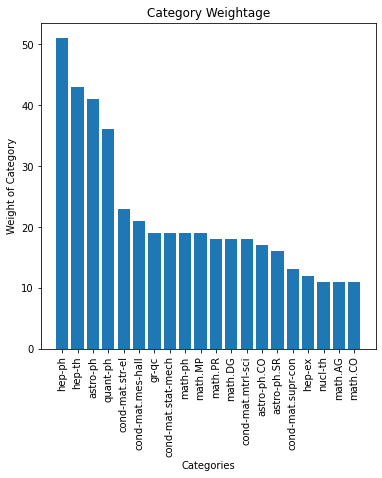

In [10]:
#Visualizing the top 20 categories as per the obtained vector
def visualize_top_cat(user_cat_vector, N=10):
    sorted_vector = sorted(user_cat_vector.items(), key=lambda x:x[1], reverse=True)
    top_N_values = list(islice(sorted_vector, N))
    labels, values = zip(*top_N_values)
    
    plt.figure(figsize=(6,6))
    x_values = [x for x in range(len(labels))]
    plt.bar(x_values, values)
    
    plt.xticks(ticks=x_values, labels=labels, rotation=90)
    plt.ylabel("Weight of Category")
    plt.xlabel("Categories")
    plt.title("Category Weightage")
    
    plt.show()

#Visual representation of top 20 categories with most views for the user
visualize_top_cat(user_cat_vector, N=20)

In [11]:
#Utility method to generate category score for recommended items
def compute_recommend_score(recommend_item, user_cat_vector, filter_records):
    score = 0
    for item in recommend_item:
        if item in filter_records:
            continue
        if item in user_cat_vector:
            score += user_cat_vector[item]
    return score

#Compute the category score for each recommendation
recommend_df['category_score'] = recommend_df['category_vectors'].apply(compute_recommend_score, 
                                                                        user_cat_vector=user_cat_vector,
                                                                        filter_records=['math.IT', 'math-ph'])

In [12]:
#Utility method to fetch first N records from recommended items based on certain feature(s)
def fetch_N_recommendations(recommend_data, features, N=50):
    recommendations = recommend_data.sort_values(features, ascending=False).head(N)
    return recommendations

#Fetch the first 1000 records based on category score for recommendations
recommendations_df = fetch_N_recommendations(recommend_df, features=['category_score', 'update_date'], N=1000)

## Title Based Filtering and Ranking:
Now that we have the top 1000 recommended items based on the category score, we can utilize the next attribute to sort these obtained papers i.e. the title of the paper/article. To perform filtering based on title, we undergo a set of preprocessing steps on the title of each paper (for both user profile dataframe as well as recommendations dataframe). I have listed these processes and the outcomes for them in a bullet list as follows:

* Lowercasing -> Converts the whole title into lowercase format
* Tokenization -> Converts the lowercased title into a set of word tokens
* Lemmatization -> Generates lemmatized words from the obtained tokens
* Stopword Removal -> Removes all tokens which are stopwords in nature
* Garbage Removal -> Removes all such characters which are useless for our case (punctuations, numbers)
* Final Result -> Joins all the tokens into a single string (removes unit length tokens) and removes extra spaces from both sides

The resultant obtained is stored as a new feature named 'preprocessed_title'.

### Tf-idf Vectorization for User Profile:
Since we need to use the user profile to compare the number of common words in documents, we will first generate tf-idf vectorizer for the user profile as well as the tf-idf vectors for it. This is done by using the __.fit_transform()__ method by passing the generated __preprocessed_title__ feature to the method.

### Tf-idf Vectorization for Recommended Documents:
The vectorizer is obtained for user_profile so that we can later use it to transform the records in the recommendations dataframe. The transform() method allows to take an already fitted vectorizer and filter out only the words from other documents that are part of the vectorizer itself. Once filtered, it then computes the tf-idf score for each word in each document. 

The tf-idf vectors that are obtained as a result of transform() method for both user profile as well as recommendations is a matrix that comprises of the words in the vectorizer as the set of columns and the different documents on which they are computed as the number of records. Thus, each cell contains the tf-idf score of a particular word (column) in a particular document (row). In our case, this gives the representation of unique words, used in the different titles that the user have viewed, in terms of the recommended paper's titles.

### Cosine Similarity between Tf-idf Vectors:
Now that both the user_profile and recommendations are represented as a set of tf-idf vectors for the same set of words, we can compute the similarity between each of the paper/article in the user profile and each paper/article in the recommendations. This is done by using pairwise cosine similarity between the two resultant tf-idf representations for the processed titles for the two dataframes. The resultant gives us a 500x1000 order matrix, where each row represents the cosine similarity for each user viewed document with all recommendation documents and each column represents the cosine similarity for each recommendation document with all the user viewed documents.

### Cosine Similarity Filtering and Ranking:
Since we require the similarity results for recommendations only (since they have to be used for recommendation purposes), we can sum the obtained results column-wise, giving us a singular vector of length 1000 (number of recommendation items). This result can be indexed before sorting so that the true index of each item can be remembered. Finally, we sort the result based on the highest similarity score to the lowest and use the indices values present with each value to fetch top 100 records with the most similarity to the titles already viewed by the user.

In [13]:
#Utility method to preprocess text
def preprocess_text(text, accepted_puncs={'_','-'}):
    lowercased = text.lower()
    tokenized = word_tokenize(lowercased)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokenized]
    stop_words = set(stopwords.words('english'))
    stopwords_free = ' '.join(x for x in lemmatized if (x not in stop_words))
    garbage_free = ''.join(x for x in stopwords_free if ((x.isalpha()) or (x in accepted_puncs) or (x == ' ')))
    final_result = ' '.join(x for x in garbage_free.split() if len(x) > 1)
    return final_result.strip()

#Preprocessing title for both dataframes
profile_df['preprocessed_title'] = profile_df['title'].apply(preprocess_text)
recommendations_df['preprocessed_title'] = recommendations_df['title'].apply(preprocess_text)

In [14]:
#Utility function to compute tf-idf vectors for each record in the user profile
def generate_user_tfidf_vector(user_data, feature_col):
    profile_vectorizer = TfidfVectorizer()
    profile_vectors = profile_vectorizer.fit_transform(user_data[feature_col])
    return profile_vectorizer, profile_vectors

#Obtain user profile vectorizer and vectors for preprocessed titles
profile_vectorizer, profile_vectors = generate_user_tfidf_vector(profile_df, 'preprocessed_title')

In [15]:
#Utility function to generate tfidf vectors for each record in recommendation items
def generate_recommend_tfidf_vector(recommend_data, feature_col, profile_vectorizer):
    recommend_vectors = profile_vectorizer.transform(recommend_data[feature_col])
    return recommend_vectors

#Obtain recommendation vectors for preprocessed titles using obtained user profile vectorizer
recommendations_vectors = generate_recommend_tfidf_vector(recommendations_df, 'preprocessed_title', profile_vectorizer)

In [16]:
#Utility function to compute pairwise cosine similarity between tf-idf vectors of documents
def compute_pairwise_cosine_similarity(profle_vectors, recommend_vectors):
    cosine_similarities = linear_kernel(profile_vectors, recommend_vectors)
    cosine_vector = np.sum(cosine_similarities, axis=0)
    return cosine_vector

#Compute cosine similarity vector for user profile and recommendation items
cosine_vector = compute_pairwise_cosine_similarity(profile_vectors, recommendations_vectors)

In [17]:
#Utility function to generate an ordered dictionary of indices for each recommendation based on similarity
def generate_similarity_indices_dict(cosine_vector):
    indices_dict = {i:v for i,v in enumerate(cosine_vector)}
    indices_dict = dict(sorted(indices_dict.items(), key = lambda x: x[1], reverse=True))
    return indices_dict

#Generate indices dict to select relevant items from recommendations
indices_dict = generate_similarity_indices_dict(cosine_vector)

In [18]:
#Utility function to fetch first N similar recommendation items
def fetch_N_closest(recommend_df, indices_dict, N=200, sort_features=None):
    top_N_indices = list(islice(indices_dict.keys(), N))
    top_N_items = recommend_df.iloc[top_N_indices]
    if sort_features:
        top_N_items = top_N_items.sort_values(sort_features, ascending=False)
    return top_N_items

#Fetch top 100 recommendation items based on the similarity score
N_closest_titles = fetch_N_closest(recommendations_df, indices_dict, N=500, sort_features='update_date')

## Abstract Based Filtering and Ranking:
The abstract based filtering makes use of the same steps as in the case of title, the difference being that we have now replaced the text in hand from titles to abstracts. The preprocessing, tf-idf generation, cosine similarity computation and recommendation filtering steps remain the same. The final output is sorted by the update date and is the resultant for our content filtering recommender.

In [19]:
#Preprocessing abstract for both dataframes
profile_df['preprocessed_abstract'] = profile_df['abstract'].apply(preprocess_text)
N_closest_titles['preprocessed_abstract'] = N_closest_titles['abstract'].apply(preprocess_text)

In [20]:
#Obtain user profile vectorizer and vectors for preprocessed abstracts
profile_vectorizer, profile_vectors = generate_user_tfidf_vector(profile_df, 'preprocessed_abstract')

In [21]:
#Obtain recommendation vectors for preprocessed abstracts using obtained user profile vectorizer
recommendations_vectors = generate_recommend_tfidf_vector(N_closest_titles, 'preprocessed_abstract', profile_vectorizer)

In [22]:
#Compute cosine similarity vector for user profile and recommendation items
cosine_vector = compute_pairwise_cosine_similarity(profile_vectors, recommendations_vectors)

In [23]:
#Generate indices dict to select relevant items from recommendations
indices_dict = generate_similarity_indices_dict(cosine_vector)

In [24]:
#Fetch top 10 recommendation items based on the similarity score
N_closest_abstracts = fetch_N_closest(N_closest_titles, indices_dict, N=100, sort_features='update_date')
N_closest_documents = N_closest_abstracts[['title', 'categories', 'abstract', 'update_date', 'category_vectors']]

In [25]:
#Displaying the top 5 recommended documents
N_closest_documents.head()

,title,categories,abstract,update_date,category_vectors
227214,Abnormal Quantum Gravity Effect: Experimental ...,gr-qc astro-ph.CO cond-mat.quant-gas hep-th ma...,From the general assumption that gravity ori...,2018-12-05,"{math-ph, gr-qc, math.MP, astro-ph.CO, cond-ma..."
94902,Dark matter and dark gauge fields,hep-ph astro-ph hep-th,Following the unexpected theoretical discove...,2017-08-23,"{astro-ph, hep-th, hep-ph}"
26479,Scaling of Entanglement Entropy at 2D quantum ...,cond-mat.str-el cond-mat.mes-hall cond-mat.sta...,The entanglement entropy of a pure quantum s...,2016-09-08,"{cond-mat.stat-mech, cond-mat.mes-hall, cond-m..."
115054,Dynamical Dirac Mass Generation in the Supersy...,hep-ph cond-mat.mes-hall cond-mat.str-el cond-...,The dynamical generation of Dirac mass in th...,2016-09-08,"{gr-qc, cond-mat.supr-con, cond-mat.mes-hall, ..."
161472,Perturbations In A Non-Uniform Dark Energy Flu...,astro-ph gr-qc hep-ph hep-th,We propose a unified single-field descriptio...,2016-05-25,"{astro-ph, hep-th, gr-qc, hep-ph}"


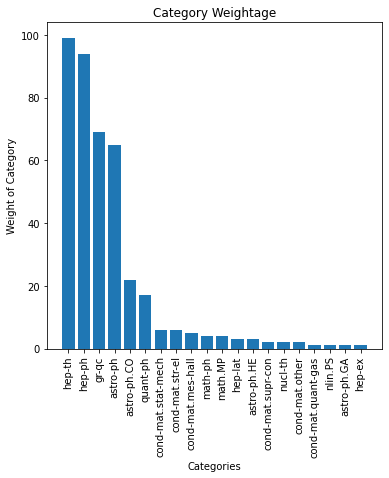

In [26]:
#Generating the recommendations category vector
recommendations_cat_vector = generate_category_vector(N_closest_documents, 'category_vectors')

#Visualizing the top categories in the recommendation documents
visualize_top_cat(recommendations_cat_vector, N=20)

This graph is somewhat related to the user profle category weightage but differs from it as well. This is because category isn't the only factor that has been used in determining the result, rather we have used similarity in titles and abstracts as well as the update_date to provide the latest ones first. These all factors combined give us a similar but not the same graph for the recommended documents. This sums up our implementation of content based filtering recommendation systems. Next time, we will look into collaborative filtering and its different implementations. Happy Learning! 